import engine
import config
import utils
from preprocess import makeDataset
import pandas as pd
import torchio as tio
import torch
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm## Segmentation of brain tumor from MRI scans

The goal is to segment different types of gliomas in pre-operative MRI scans. The [dataset](https://www.med.upenn.edu/cbica/brats2020/data.html) used contains multimodal scans available as NIfTI files (.nii.gz) which describe:

* native (T1),
* post-contrast T1-weighted (T1Gd),
* T2-weighted (T2),
* T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes, 
which were acquired with different clinical protocols and various scanners from 19 institutions.

Each MRI consists of 155 240 x 240 patches, in which each pixel is part of a tumor area.
All MRIs have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise 
* the GD-enhancing tumor (ET — label 4), 
* the peritumoral edema (ED — label 2), 
* and the necrotic and non-enhancing tumor core (NCR/NET — label 1). 

The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.

In [ ]:
import engine
import config
import utils
from preprocess import makeDataset
import pandas as pd
import torchio as tio
import torch
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm

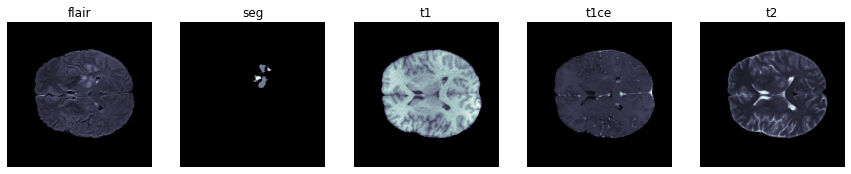

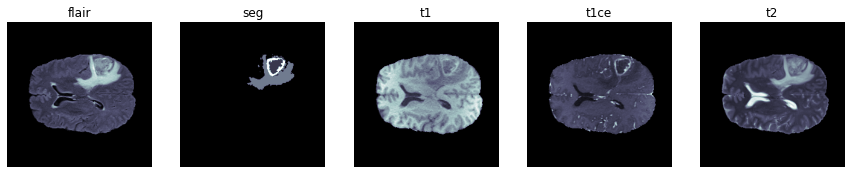

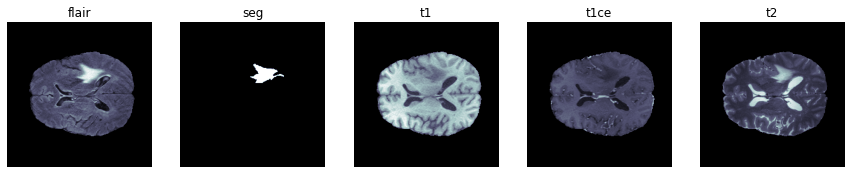

In [3]:
df = utils.makeFileList()
for _, paths in df.sample(n = 3, random_state = 1).iterrows():
    utils.plotSample(paths)

### Data split and preprocessing

We will use all MRI types apart from t1 as it does not seem to contain additional information.
The dataset will be split to train/validation/test sets. Each MRI will be treated as 155 different images of dimensions 240 x 240. From each image, a set of overlapping patches is extracted, and patches containing at least one of the classes are retained (i.e. background only patches are discarded).
The patches retained are written to .h5 files for faster loading during training

In [2]:
# Split the files
traindf, valdf, testdf = utils.split(df)

# Extract patches from the data and save them
noTrainSamples = makeDataset(dataframe = traindf, filename = '/kaggle/working/train.h5')
noValSamples   = makeDataset(dataframe = valdf,   filename = '/kaggle/working/val.h5')

print(f'{noTrainSamples} training images')
print(f'{noValSamples} validation images')

45375 training images
10263 validation images


### Transformation configuration

In [5]:
include      = ['x1', 'x2', 'x3', 'y']
label_keys   = 'y'
labelMapping = {0:0, 1:1, 2:2, 4:3}

# Spatial transformations
spatial = tio.OneOf({
            tio.RandomFlip(flip_probability = 1, axes  = (0, 1), 
                include = include, label_keys = label_keys) : 0.35,
            tio.RandomAffine(degrees = 20,
                include = include, label_keys = label_keys) : 0.35,                                
            tio.RandomAnisotropy(downsampling = (1.5, 2.5), axes = (0, 1),
                include = include, label_keys = label_keys) : 0.15,
            tio.RandomElasticDeformation(max_displacement = (2, 2, 0),
                include = include, label_keys = label_keys) : 0.15},
            p = 0.95)

# Intensity transformations
intensity = tio.OneOf({
                tio.RandomNoise(std = 0.1,
                    include = include, label_keys = label_keys) : 0.5,
                tio.RandomBiasField(coefficients = 0.1,
                    include = include, label_keys = label_keys): 0.5},
                p = 0.95)

# Histogram stretching
hist  = tio.RescaleIntensity(out_min_max = (-1, 1), percentiles = (0.5, 99.5),
            masking_method = utils.maskFunction, include = include, label_keys = label_keys)

# Padding if needed
pad   = tio.CropOrPad(target_shape = (128, 128, 1), padding_mode = 'minimum', include = include, label_keys = label_keys)

# Label remapping
remap = tio.RemapLabels(labelMapping, include = include, label_keys = label_keys)

# Final
trainTransform = tio.Compose([pad, spatial, hist, intensity, remap], copy = False)
valTransform   = tio.Compose([pad, hist, remap], copy = False)
testTransform  = tio.Compose([hist, remap], copy = False)

### Training

Unet will be used with a resnet encoder according to the configuration file, Focal loss is used as the criterion with Adam and LR reduction on validation loss plateau.

In [6]:
trainloader = DataLoader(
                dataset     = utils.BRATSDataset(config.TRAIN_FILE, noTrainSamples, trainTransform),
                batch_size  = config.BATCHSIZE,
                num_workers = config.LOADER_WORKERS,
                pin_memory  = True,
                shuffle     = True)

valloader  = DataLoader(
                dataset     = utils.BRATSDataset(config.VAL_FILE, noValSamples, valTransform),
                batch_size  = config.BATCHSIZE,
                num_workers = config.LOADER_WORKERS,
                pin_memory  = True,
                shuffle     = False)


model       = smp.Unet(encoder_name     = config.ENCODER_NAME,
                       encoder_weights  = config.ENCODER_WEIGHTS,
                       encoder_depth    = config.ENCODER_DEPTH,
                       in_channels      = config.ENCODER_IN_CHANNEL,
                       decoder_channels = config.DECODER_CHANNELS,
                       classes          = config.NO_CLASSES)

criterion   = smp.losses.FocalLoss(mode  = 'multiclass', gamma = config.LOSS_GAMMA)
optimizer   = torch.optim.Adam(model.parameters(), lr = config.LEARN_RATE, weight_decay = config.WEIGHT_DECAY)
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose = True,
                                                         factor   = config.SCHEDULER_FACTOR,
                                                         patience = config.SCHEDULER_PATIENCE)

In [ ]:
model.to(config.DEVICE)

# Load from a checkpoint if exists
model, optimizer, scheduler, scaler, curEpoch, trainLoss, valLoss, bestValLoss = \
    utils.loadCheckpoint(model, optimizer, scheduler, scaler, config.LAST_CHECKPOINT)

for epoch in range(curEpoch, config.EPOCHS):

    trainLoss   = engine.train(model, criterion, optimizer, scaler, trainloader) / noTrainSamples
    valLoss     = engine.validate(model, criterion, valloader) / noValSamples
    if scheduler is not None: scheduler.step(valLoss)
    bestValLoss = utils.makeCheckpoint(epoch, model, optimizer, scheduler, scaler, trainLoss, valLoss, bestValLoss)
    
    
trainloader.dataset.file.close() # Close .h5 files at the end of training/validation
valloader.dataset.file.close() 

### Test set predictions

In [ ]:
model.eval()

saveOutput = True
TP, FP, FN, TN = 0, 0, 0, 0

with torch.no_grad():

    for idx, paths in tqdm(testdf.iterrows(), total = testdf.shape[0]):
        
        # Predict
        x, y, yhat = engine.predict(paths, model,
                                    transform   = testTransform, 
                                    patchStride = config.PATCH_SIZE, # No overlap
                                    device      = 'cpu')
        
        # Grab stats
        tp, fp, fn, tn = smp.metrics.functional.get_stats(yhat, y, mode = 'multiclass', 
                                                          num_classes = config.NO_CLASSES)
        TP += tp.sum(dim = 0)
        FP += fp.sum(dim = 0)
        FN += fn.sum(dim = 0)
        TN += tn.sum(dim = 0)
    
        # Save to file
        if saveOutput: 
            utils.makeGifs(x, y, yhat, folder = '/outputs/' + str(idx) + '/')

# Print metrics on tumor classes
utils.computeMetrics(TP, FP, FN, TN)